## Feature Pipeline for the `lahinch` feature group

This feature pipeline can be run on a schedule using github actions (see github repo for the example file).

### Requirements

 * hopsworks

In [1]:
#!pip install -U hopsworks
import duckdb

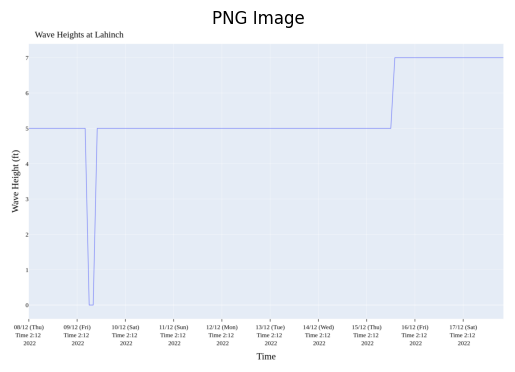

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the PNG image
image_path = 'latest_lahinch.png'  # Replace with your actual file path
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("PNG Image")
plt.show()


In [ ]:
import os
import re
import pandas as pd
import parsedatetime
from datetime import datetime
import numpy as np
import requests
import hopsworks

### Not app.hopsworks.ai ?

If you are running your own Hopsworks cluster (not app.hopsworks.ai):

 * uncomment the cell below
 * fill in details for your cluster
 * run the cel

In [ ]:
# Uncomment this cell and fill in details if you are running your own Hopsworks cluster
# key=""
# with open("api-key.txt", "r") as f:
#     key = f.read().rstrip()
# os.environ['HOPSWORKS_PROJECT']="cjsurf"
# os.environ['HOPSWORKS_HOST']="35.187.178.84"
# os.environ['HOPSWORKS_API_KEY']=key

### Backfill the feature group 

If you set `BACKFILL` to `True` in the cell below, and continue running all the cells, you will insert surf height observations from the `lahinch-surf.csv` file into the `lahinch` feature group.

When `BACKFILL` is `False`, it will download the latest surf report from Lahinch Surf Shop and insert it into the `lahinch` feature group.

In [ ]:
BACKFILL=False
if os.environ.get('BACKFILL') == "False":
    BACKFILL=False
version=1
url="https://www.lahinchsurfshop.com/"
backfill_url="https://repo.hops.works/master/hopsworks-tutorials/data/cjsurf/lahinch-surf.csv"

When `BACkFILL` is `False`, we scrape the surf height for today from the Lahinch surf shop webpage.

In [ ]:
if BACKFILL == False:
    filepath = 'index.html'
    if os.path.exists(filepath):
        os.remove(filepath)
    response = requests.get(url)
    open(filepath, "wb").write(response.content)    

    cal = parsedatetime.Calendar()
    data = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        the_date = None
        img_url = None
        max_height = None
        min_height = None
        regex = None
        while line:
            if "Last updated" in line:
                #: June 13, 2022
                str = line.partition("Last updated</b>:")[2]
                date_str = str.partition("</p>")[0]
                # fix the time to 10am
                date_str = date_str + " 10am"
                time_struct, parse_status = cal.parse(date_str)
                the_date = datetime(*time_struct[:6])
            if "Wave height" in line:
                str = line.partition("Wave height</b>:")[2]
                height_str = str.partition(", Sea")[0]
                regex = re.match(r'.*([0-9]+)-([0-9]+)ft.*', height_str)
                if regex is not None:
                    min_height=regex.groups()[0]
                    max_height=regex.groups()[1]
                    height = (float(min_height)+float(max_height))/2
                else:
                    regex = re.findall(r'.*([0-9]+)ft', height_str)
                    if len(regex):
                        max_height=regex[0]
                        min_height=regex[0]
                        height=regex[0]
                    else:
                        regex = re.findall(r'.*([4-9]+)inches', height_str)
                        if len(regex):
                            max_height="0.5"
                            min_height="0"
                            height="0.5"
                        else:
                            max_height="0"
                            min_height="0"
                            height="0"
                    
            if regex is not None:
                if the_date is not None:
                    row=[the_date, height, max_height, min_height]
                    data.append(row)
                    the_date = None
                    regex = None
            line = fp.readline()
            cnt += 1

    df = pd.DataFrame(data, columns=['observation_time', 'wave_height', 'max_height', 'min_height'])
    df['beach_id'] = 1
    
else: # BACKFILL == True
    df = pd.read_csv(backfill_url, parse_dates=['observation_time'])

df['wave_height'] = pd.to_numeric(df['wave_height'] , errors='coerce').astype(np.float64)
df['max_height'] = pd.to_numeric(df['max_height'] , errors='coerce').astype(np.float64)
df['min_height'] = pd.to_numeric(df['min_height'] , errors='coerce').astype(np.float64)
    
df

## Validate your feature data

We add a validation rule here that the `wave_height` should not be lower than `0` or greater than `20` feet high.

In the `lahinch` feature group user interface, you will see the results of the data ingestions and if this data validation rule passed for all ingestions or not.

In [ ]:
import great_expectations as ge

expectation_suite = ge.core.ExpectationSuite(expectation_suite_name="surf_height")

expectation_suite.add_expectation(
  ge.core.ExpectationConfiguration(
  expectation_type="expect_column_values_to_be_between",
  kwargs={"column":"wave_height", "min_value": 0, "max_value": 20}) 
);

### Connect to your Hopsworks cluster

If you only set the HOPSWORKS_API_KEY, it will assume you are connecting to app.hopsworks.ai.
Set HOPSWORKS_HOST and HOPSWORKS_PROJECT environment variables to connect to a different Hopsworks cluster.

Then write your DataFrame to the `lahinch` feature group.

In [ ]:
project = hopsworks.login()

fs = project.get_feature_store()
lahinch_fg = fs.get_or_create_feature_group(name="lahinch",
        description="Lahinch beach surf height observations",
        online_enabled=True,
        version=version,
        primary_key=["beach_id"],
        expectation_suite=expectation_suite,
        statistics_config={"enabled": True, "histograms": True, "correlations": True},
        event_time="observation_time")

_, _ = lahinch_fg.insert(df)